<a href="https://colab.research.google.com/github/swalehaparvin/ML_for_CyberSecurity/blob/main/White_Box_Attack_with_Fast_Gradient_Sign_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# White-Box Attack with Fast Gradient Sign Method (FGSM)

## Objective:
Through this tutorial, we aim to provide insights into the vulnerability of deep learning models to adversarial attacks and demonstrate the practical implementation of the Fast Gradient Sign Method (FGSM) technique.

Adversarial attacks involve intentionally manipulating input data to mislead machine learning models. FGSM is a white-box attack, meaning it assumes complete knowledge of the model architecture and parameters. A deep dive into FGSM could be found here.

This demonstration utilizes a Convolutional Neural Network (CNN) tr on the CIFAR-10 dataset. We randomly select an image, generate an adversarial example using FGSM, and visualize the original and manipulated images along with their predicted labels.

## Import Libraries
Import necessary libraries for the tutorial, including PyTorch, torchvision, matplotlib, and numpy.

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

## Define Model
Define a simple convolutional neural network (CNN) architecture for image classification with PyTorch.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Load Dataset
Load the CIFAR-10 dataset and set up a data loader with image normalization and transformation.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43874962.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Initialize the model
Initialize the model, move it to GPU (if available), and set it to training mode

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the model
Train the model for a specified number of epochs, print training and validation statistics, and save the trained model.

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 1.3535, Train Accuracy: 0.5136, Val Accuracy: 0.5984
Epoch 2/5, Loss: 0.9941, Train Accuracy: 0.6493, Val Accuracy: 0.6545
Epoch 3/5, Loss: 0.8373, Train Accuracy: 0.7051, Val Accuracy: 0.6894
Epoch 4/5, Loss: 0.7258, Train Accuracy: 0.7440, Val Accuracy: 0.6888
Epoch 5/5, Loss: 0.6347, Train Accuracy: 0.7780, Val Accuracy: 0.7040


## Save Trained Model
Save the trained model parameters to a file for later use.

In [ ]:
torch.save(model.state_dict(), 'cifar10_model.pth')

## Load Pre-trained Model
Load a pre-trained CNN model for image classification on CIFAR-10 using PyTorch.

In [ ]:
model = SimpleCNN()
model.load_state_dict(torch.load('cifar10_model.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Choose Random Test Image
Randomly select an image from the CIFAR-10 test dataset and print its original label.

In [ ]:
index = np.random.randint(0, len(test_dataset))
original_image, original_label = test_dataset[index]
print("Original Label:", original_label)

Original Label: 8


## Fast Gradient Sign Method (FGSM)
Implement the Fast Gradient Sign Method (FGSM) to generate adversarial examples for the selected test image.

In [ ]:
def generate_adversarial_example(model, image, label, epsilon=0.02):
    """
    Function to generate adversarial examples using Fast Gradient Sign Method (FGSM).

    Parameters:
    - model: Pre-trained neural network model
    - image: Original image tensor
    - label: True label of the original image
    - epsilon: Perturbation magnitude for FGSM

    Returns:
    - adversarial_image: Adversarial image tensor
    """
    image.requires_grad = True
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([label]))

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * torch.sign(image.grad)
    adversarial_image = image + perturbation
    return adversarial_image.detach()

## Generate Adversarial Examples
Use the previously defined functions to generate an adversarial image and print the predicted labels.

In [ ]:
original_image = original_image.unsqueeze(0)
adversarial_image = generate_adversarial_example(model, original_image, original_label)
original_prediction = torch.argmax(model(original_image))
adversarial_prediction = torch.argmax(model(adversarial_image))

## Plot Original and Adversarial Images
Defining the function to visualize the original and adversarial images

In [ ]:
def plot_images(original, adversarial, original_label, adversarial_label):
    """
    Function to plot the original and adversarial images side by side.

    Parameters:
    - original: Original image tensor
    - adversarial: Adversarial image tensor
    - original_label: Original image label
    - adversarial_label: Adversarial image label
    """
    plt.figure(figsize=(2, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(original, (1, 2, 0)))
    plt.title(f'Original\nLabel: {original_label.item()}')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(adversarial, (1, 2, 0)))
    plt.title(f'Adversarial\nLabel: {adversarial_label.item()}')

    plt.show()

Visualize the original and adversarial images along with their predicted labels for comparison.

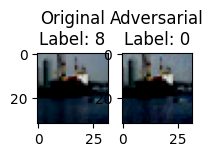

In [ ]:
plot_images(original_image.squeeze().detach().numpy(), adversarial_image.squeeze().detach().numpy(), original_prediction, adversarial_prediction)

## Conclusion
Upon visualizing the original and adversarial images, it becomes evident that the FGSM perturbation is sufficient to mislead the model. The misclassification of the adversarial image, despite its visual similarity to the original, underscores the sensitivity of the model to imperceptible changes in the input.

Hence, adversarial attacks, such as the white-box attack demonstrated with the Fast Gradient Sign Method (FGSM), highlight the vulnerability of deep neural networks to subtle input manipulations. In this tutorial, we utilized a pre-trained Convolutional Neural Network (CNN) on the CIFAR-10 dataset to showcase the effectiveness of FGSM in crafting adversarial examples.